<a href="https://colab.research.google.com/github/sarahhasan1212/DataScienceProject1/blob/main/SaraMiniProject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,585 kB]
Get:14 https://r2u.stat

In [2]:
!pip install chromedriver-autoinstaller
import chromedriver_autoinstaller
chromedriver_autoinstaller.install()

'/usr/local/lib/python3.10/dist-packages/chromedriver_autoinstaller/129/chromedriver'

In [3]:
!pip install selenium-stealth

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import csv


chrome_options = Options()
chrome_options.add_argument('--headless')  # Run Chrome in headless mode
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--window-size=2560,1440")


#Scrapping the Data of 50 Pages

driver = webdriver.Chrome(options=chrome_options)

base_url = "https://www.skinnytaste.com/recipe-index/?_paged={}"

driver.maximize_window()
time.sleep(2)

def scrape_page_links():
    posts = driver.find_elements(By.CSS_SELECTOR, 'h2.entry-title a')
    images = driver.find_elements(By.CSS_SELECTOR, '.post-thumb img')
    links = []

    # Collect all the recipe links and corresponding images
    for i in range(len(posts)):
        post = posts[i]


        img_url = images[i].get_attribute('src') if i < len(images) else 'N/A'

        title = post.text
        link = post.get_attribute('href')

        links.append({'title': title, 'link': link, 'image': img_url})

    return links

def scrape_recipe(link):
    driver.get(link)
    time.sleep(3)

    # Scraping ww points
    try:
        ww_points = driver.find_element(By.CSS_SELECTOR, 'span.recipe-meta-value.recipe-ww-pp.icon').text
    except:
        ww_points = " "

    # Scraping Calories
    try:
        calorie = driver.find_element(By.CSS_SELECTOR, 'span.recipe-meta-value.value-calories').text
        calories = float(calorie.split(":")[1].strip())
    except:
        calories = " "
    try:
        summary = driver.find_element(By.CSS_SELECTOR, "div.entry-content.clear p:first-of-type").text
    except:
        summary = " "


    # Scraping Recipe Keys
    try:
        recipe_keys_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.cat-icons.post-icons li a')
        recipe_keys = [key.text for key in recipe_keys_elements]  # Get text like "DF", GF", etc.
    except:
        recipe_keys = []

    if not recipe_keys:
        recipe_keys = " "
    recipe_keys = ', '.join(recipe_keys)


    return ww_points, calories, summary, recipe_keys


all_data = []
for page_number in range(1, 3):
    driver.get(base_url.format(page_number))
    time.sleep(5)
    print(f"Scraping page {page_number}...")


    recipe_links = scrape_page_links()


    for index, recipe in enumerate(recipe_links, start=1):
        print(f"Scraping recipe {index}: {recipe['title']} - {recipe['link']}")

        ww_points, calories, summary, recipe_keys = scrape_recipe(recipe['link'])  # Scrape WW Points, calories, and recipe keys

        # Append the data with the recipe index, WW Points, image, calories, and recipe keys
        all_data.append({
            'index': index,
            'title': recipe['title'],
            'link': recipe['link'],
            'ww_points': ww_points,
            'image': recipe['image'],
            'calories': calories,
            'summary': summary,
            'recipe_keys': recipe_keys
        })

# Generate CSV
csv_file = "SkinnyData.csv"

# Map the headers of Recipe Keys

rename_keys = {
  'DF': 'Key1',
  'GF': 'Key2',
  'AF': 'Key3',
  'FM': 'Key4',
  'HF': 'Key5',
  'HP': 'Key6',
  'KF': 'Key7',
  'LC': 'Key8',
  'MP': 'Key9',
  'Q':  'Key10',
  'V':  'Key11',
  'W':  'Key12',
  'SC': 'Key13',
}

csv_columns = ['index', 'title', 'link', 'ww_points', 'image', 'calories', 'summary'] + list(rename_keys.values())

try:
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=csv_columns)
        writer.writeheader()

        for recipe in all_data:

            recipe_data = {key: recipe[key] for key in ['index', 'title', 'link', 'ww_points', 'image', 'calories', 'summary']}

            renamed_recipe_keys = {v: "" for v in rename_keys.values()}

            for key in recipe['recipe_keys'].split(', '):
                if key in rename_keys:
                    renamed_recipe_keys[rename_keys[key]] = key

            recipe_data.update(renamed_recipe_keys)
            writer.writerow(recipe_data)

    print(f"{csv_file} Success!")
except IOError:
    print("Error in writing to CSV file.")


In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

# CSV data to be loaded in Pandas DataFrame
df = pd.read_csv(list(uploaded.keys())[0])

print(df.to_markdown(index=False))

Saving SkinnyData.csv to SkinnyData (1).csv
|   index | title                                                                                   | link                                                                                                             | ww_points   | image                                                                                                                                                                                                        | calories   | summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
# Filteration of Interesting Data
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import csv

#Headless Mode
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--window-size=2560,1440")


driver = webdriver.Chrome(options=chrome_options)

base_url = "https://www.skinnytaste.com/recipe-index/?_paged={}"

driver.maximize_window()
time.sleep(2)

def scrape_page_links():
    posts = driver.find_elements(By.CSS_SELECTOR, 'h2.entry-title a')
    images = driver.find_elements(By.CSS_SELECTOR, '.post-thumb img')
    links = []

    # Getting the recipe links and their images
    for i in range(len(posts)):
        post = posts[i]
        img_url = images[i].get_attribute('src') if i < len(images) else 'N/A'
        title = post.text
        link = post.get_attribute('href')
#appending the data
        links.append({'title': title, 'link': link, 'image': img_url})

    return links

def scrape_recipe(link):
    driver.get(link)
    time.sleep(3)

    # Scraping WW Points, Calories, Summary and Recipe Keys
    try:
        ww_points = driver.find_element(By.CSS_SELECTOR, 'span.recipe-meta-value.recipe-ww-pp.icon').text
    except:
        ww_points = " "

    try:
        calorie = driver.find_element(By.CSS_SELECTOR, 'span.recipe-meta-value.value-calories').text
        calories = float(calorie.split(":")[1].strip())
    except:
        calories = " "

    try:
        summary = driver.find_element(By.CSS_SELECTOR, "div.entry-content.clear p:first-of-type").text
    except:
        summary = " "

    try:
        recipe_keys_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.cat-icons.post-icons li a')
        recipe_keys = [key.text for key in recipe_keys_elements]
    except:
        recipe_keys = []


    if not recipe_keys:
        recipe_keys = " "

    recipe_keys = ', '.join(recipe_keys)


    return ww_points, calories, summary, recipe_keys


all_data = []
for page_number in range(1, 2):
    driver.get(base_url.format(page_number))
    time.sleep(5)
    print(f"Scraping page {page_number}...")

    recipe_links = scrape_page_links()

# Iterate each recipe and scrape the WW Points, calories, and recipe keys
    for index, recipe in enumerate(recipe_links, start=1):
        print(f"Scraping recipe {index}: {recipe['title']} - {recipe['link']}")

        ww_points, calories, summary, recipe_keys = scrape_recipe(recipe['link'])

# Append the data with the recipe index, WW Points, image, calories, and recipe keys
        all_data.append({
            'index': index,
            'title': recipe['title'],
            'link': recipe['link'],
            'ww_points': ww_points,
            'image': recipe['image'],
            'calories': calories,
            'summary': summary,
            'recipe_keys': recipe_keys
        })

# Data Filtering Functions
def filter_by_calories(data, max_calories=300):
    return [recipe for recipe in data if recipe['calories'] != " " and float(recipe['calories']) <= max_calories]

def filter_by_recipe_keys(data, required_key="V"):
    return [recipe for recipe in data if required_key in recipe['recipe_keys']]

def filter_by_ww_points(data, max_ww_points=5):
    return [recipe for recipe in data if recipe['ww_points'] != " " and float(recipe['ww_points']) <= max_ww_points]

# Apply Filters
filtered_data = filter_by_calories(all_data, max_calories=300)
filtered_data = filter_by_recipe_keys(filtered_data, required_key="V")
filtered_data = filter_by_ww_points(filtered_data, max_ww_points=5)


csv_file = "filtered_Data.csv"

# Specify the field names for the CSV file
rename_keys = {
  'DF': 'Key1',
  'GF': 'Key2',
  'AF': 'Key3',
  'FM': 'Key4',
  'HF': 'Key5',
  'HP': 'Key6',
  'KF': 'Key7',
  'LC': 'Key8',
  'MP': 'Key9',
  'Q':  'Key10',
  'V':  'Key11',
  'W':  'Key12',
  'SC': 'Key13',
}

csv_columns = ['index', 'title', 'link', 'ww_points', 'image', 'calories', 'summary'] + list(rename_keys.values())

try:
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=csv_columns)
        writer.writeheader()

        for recipe in filtered_data:

            recipe_data = {key: recipe[key] for key in ['index', 'title', 'link', 'ww_points', 'image', 'calories', 'summary']}
            renamed_recipe_keys = {v: "" for v in rename_keys.values()}

            for key in recipe['recipe_keys'].split(', '):
                if key in rename_keys:
                    renamed_recipe_keys[rename_keys[key]] = key

            recipe_data.update(renamed_recipe_keys)

            writer.writerow(recipe_data)

    print(f"{csv_file} created successfully")
except IOError:
    print("Error while writing to CSV file.")


Scraping page 1...
Scraping recipe 1: Free 7 Day Healthy Meal Plan (Sept 30-Oct 6) - https://www.skinnytaste.com/free-7-day-healthy-meal-plan-sept-30-oct-6/
Scraping recipe 2: Breakfast Burritos - https://www.skinnytaste.com/freezer-breakfast-burritos/
Scraping recipe 3: Crustless Pumpkin Pie - https://www.skinnytaste.com/crustless-pumpkin-pie/
Scraping recipe 4: Red Curry Salmon - https://www.skinnytaste.com/red-curry-salmon/
Scraping recipe 5: Apple Butter - https://www.skinnytaste.com/apple-butter-recipe/
Scraping recipe 6: Roasted Delicata Squash - https://www.skinnytaste.com/roasted-delicata-squash/
Scraping recipe 7: Apple Bread - https://www.skinnytaste.com/applesauce-nut-bread/
Scraping recipe 8: Autumn Salad with Pears and Gorgonzola - https://www.skinnytaste.com/autumn-salad-with-pears-and-gorgonzola/
Scraping recipe 9: Sesame Chicken - https://www.skinnytaste.com/sesame-chicken/
Scraping recipe 10: Bacon in the Oven - https://www.skinnytaste.com/bacon-in-the-oven/
Scraping r

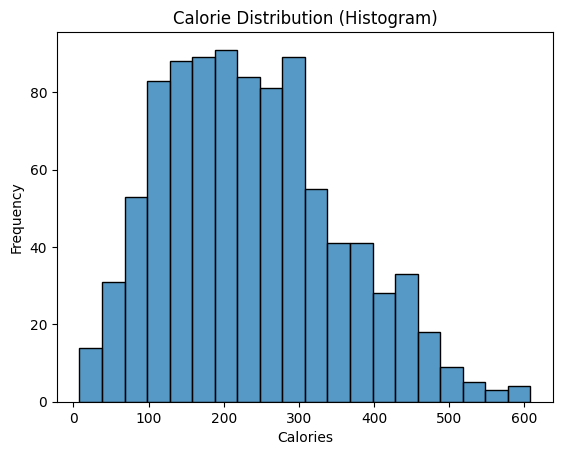

In [ ]:
#Calories Visualisation

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


sns.histplot(data=df, x='calories', bins=20)

plt.xticks([0, 100, 200, 300, 400, 500, 600], ['0', '100', '200', '300', '400', '500', '600'])

plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Calorie Distribution (Histogram)')
plt.show()

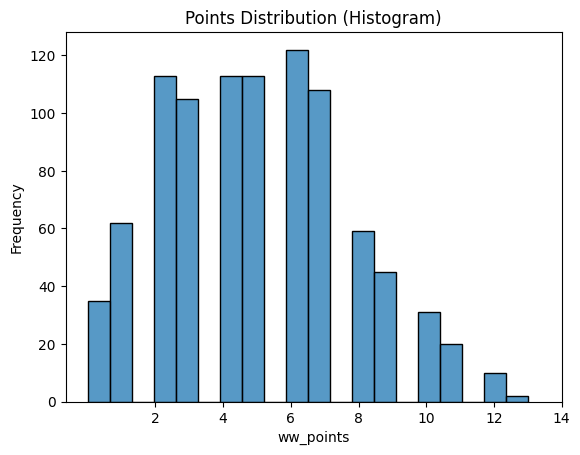

In [ ]:
# ww points visualisation

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


sns.histplot(data=df, x='ww_points', bins=20)

plt.xticks([2, 4, 6, 8, 10, 12, 14], ['2', '4', '6', '8', '10', '12', '14'])

plt.xlabel('ww_points')
plt.ylabel('Frequency')
plt.title('Points Distribution (Histogram)')
plt.show()

Saving SkinnyData.csv to SkinnyData.csv


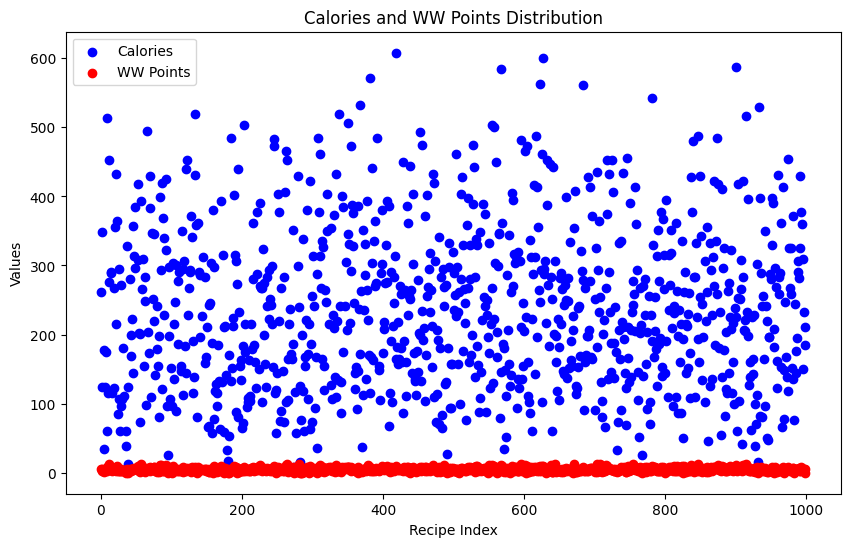

In [ ]:
#Corelation between calories and ww points
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
df.dropna(subset=['calories', 'ww_points'], inplace=True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

calories_column = 'calories'
ww_points_column = 'ww_points'

df[calories_column] = pd.to_numeric(df[calories_column], errors='coerce')
df[ww_points_column] = pd.to_numeric(df[ww_points_column], errors='coerce')

df = df.dropna(subset=[calories_column, ww_points_column])

plt.figure(figsize=(10, 6))

plt.scatter(df.index, df[calories_column], color='blue', label='Calories')

plt.scatter(df.index, df[ww_points_column], color='red', label='WW Points')

plt.title('Calories and WW Points Distribution')
plt.xlabel('Recipe Index')
plt.ylabel('Values')
plt.legend()

plt.show()


Saving SkinnyData.csv to SkinnyData (1).csv
Counts for each key:
 Key2     700
Key7     515
Key10    460
Key1     442
Key11    406
Key8     274
Key5     245
Key6     213
Key9     152
Key4     143
Key12    121
Key3     107
Key13     29
dtype: int64
Mean of key counts: 292.84615384615387
Standard deviation of key counts: 196.4505222500253


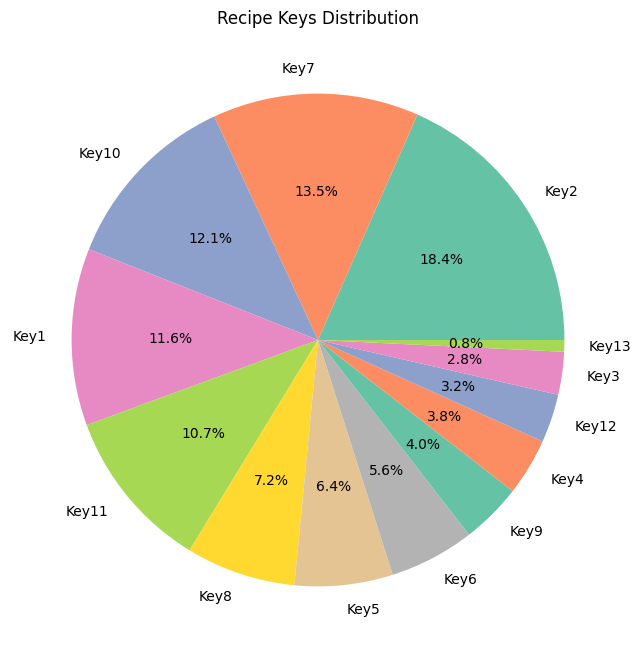

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])

key_columns = [f'Key{i}' for i in range(1, 14)]

if all(key in df.columns for key in key_columns):
    recipe_keys_df = df[key_columns]

    key_frequencies = recipe_keys_df.notna().sum().sort_values(ascending=False)

    print("Counts for each key:\n", key_frequencies)

    mean_key_frequency = key_frequencies.mean()
    std_key_frequency = key_frequencies.std()

    print("Mean of key counts:", mean_key_frequency)
    print("Standard deviation of key counts:", std_key_frequency)

    top_keys = key_frequencies.head(1000)

    plt.figure(figsize=(8, 8))
    plt.pie(top_keys, labels=top_keys.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
    plt.title('Recipe Keys Distribution')
    plt.show()

else:
    print("Some key columns are missing in the dataset.")

In [ ]:
import pandas as pd
from google.colab import files


uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

# Converting calories and ww_points to numeric
df['calories'] = pd.to_numeric(df['calories'], errors='coerce')
df['ww_points'] = pd.to_numeric(df['ww_points'], errors='coerce')

# Filter based on calories and ww_points
def filter_recipes(df, min_calories, max_calories, min_points, max_points):

    filtered_df = df[
        (df['calories'].between(min_calories, max_calories)) &
        (df['ww_points'].between(min_points, max_points))
    ]

    sorted_df = filtered_df.nsmallest(10, 'calories')
    return sorted_df

try:
    min_calories = int(input("Enter minimum calories: "))
    max_calories = int(input("Enter maximum calories: "))
    min_points = int(input("Enter minimum WW points: "))
    max_points = int(input("Enter maximum WW points: "))

except ValueError:
    print("Please enter valid numeric values for the ranges.")
    exit()

filtered_sorted_df = filter_recipes(df, min_calories, max_calories, min_points, max_points)

# Display the first 10 foods with image and summary
if not filtered_sorted_df.empty:
    print("\nFirst 10 Foods based on your input ranges:\n")
    for index, row in filtered_sorted_df.iterrows():
        print(f"Title: {row['title']}")
        print(f"Calories: {row['calories']}")
        print(f"WW Points: {row['ww_points']}")
        print(f"Summary: {row['summary']}")
        print(f"Image: {row['image']}")
        print('-' * 50)
else:
    print("Sorry!No data in this range.")


Saving SkinnyData.csv to SkinnyData (3).csv
Enter minimum calories: 12
Enter maximum calories: 12
Enter minimum WW points: 12
Enter maximum WW points: 12
Sorry!No data in this range.


In [6]:
import pandas as pd
from google.colab import files


uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])

df['ww_points'] = pd.to_numeric(df['ww_points'], errors='coerce')

df = df.dropna(subset=['ww_points'])

average_points = df['ww_points'].mean()
standard_deviation = df['ww_points'].std()

# Print the results
print("Average Points:", average_points)
print("Standard Deviation:", standard_deviation)

Saving SkinnyData.csv to SkinnyData (1).csv
Average Points: 4.96908315565032
Standard Deviation: 2.7977165966726525
